# Uncertainty estimation

This notebook performs uncertainty quantification for the U-Net model

In [1]:
from pathlib import Path
import random

import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread

import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from carde.io import image_path, tiled_image_path, tiled_label_path
from carde.dataset import SEMTileDataset, split_data
from carde.unet import SegmentationModel, SegmentationModel_mve, NLLWarmupCallback, get_latest_checkpoint_path, load_model
from carde.evalmetrics import (
    plot_confidence_map,
    plot_confidence_map,
    compute_nll,
    compute_ece,
    plot_reliability_diagram,
    probs_to_confidence_map,
)

## Figure parameters

In [2]:

devices=(4,) # which GPU devices to use, e.g. (0,1) for multi-GPU training
device_name = "cuda"
_ = torch.manual_seed(42)
np.random.seed(5)
random.seed(23)

# figure parameters
plt.rcParams['svg.fonttype'] = 'none'  # editable text in svg vector formats
plt.rcParams['font.size'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = plt.rcParams['xtick.labelsize']

# figure sizes
textwidth = 7.05  # inches
onecolumn = 3.42  # inches
# set the default figure size to one column width
plt.rcParams["figure.figsize"] = (textwidth, onecolumn)

figure_path = Path('../paper/figures')
figure_path.mkdir(parents=True, exist_ok=True)

## Image metadata for scale bars

In [3]:
pixel_size = 8  # nanometers per pixel
scale_bar_length = 300  # nanometers
scale_bar_length_px = scale_bar_length / pixel_size  # in pixels

## Data and model architecture

In [4]:
raw_image_path = image_path.parent.parent / "01-02"
se2_image = imread(raw_image_path / "Original SEM Images" / "WD_06mm_001.tif")
in_lens_image = imread(raw_image_path / "Original SEM Images" / "WD_06mm_002.tif")
label_image = imread(raw_image_path / "05a_Particle_Image_Filtered.bmp")

## Model training

In [5]:
model_path = tiled_label_path.parent.parent / "tb_logs"
model_name = "unet_model"
model_path.mkdir(parents=True, exist_ok=True)

In [6]:
# create dataset
dataset = SEMTileDataset(tiled_image_path, tiled_label_path, train=True)
# create dataloader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# split data into three sets: train, validation, and test
train_loader, val_loader, test_loader = split_data(dataset, batch_size=32, train_ratio=0.8, val_ratio=0.1)

In [7]:
print(f"Batches in training data loader: {len(train_loader)}")
print(f"Batches in validation data loader: {len(val_loader)}")
print(f"Batches in test data loader: {len(test_loader)}")

print(f"Number of samples in training data loader: {len(train_loader.dataset)}")
print(f"Number of samples in validation data loader: {len(val_loader.dataset)}")
print(f"Number of samples in test data loader: {len(test_loader.dataset)}")

total_samples = len(train_loader.dataset) + len(val_loader.dataset) + len(test_loader.dataset)
print(f"Total number of samples: {total_samples}")


Batches in training data loader: 48
Batches in validation data loader: 6
Batches in test data loader: 6
Number of samples in training data loader: 1536
Number of samples in validation data loader: 192
Number of samples in test data loader: 192
Total number of samples: 1920


In [8]:
# TensorBoard Logger
logger = TensorBoardLogger(str(model_path), name=model_name)
logger

In [9]:
# training the model
early_stop_callback = EarlyStopping(monitor="validation_loss", mode="min", patience=14, verbose=True)

trainer = pl.Trainer(
    max_epochs=1000,
    accelerator="gpu",
    devices=devices,
    enable_progress_bar=True,
    callbacks=[early_stop_callback],
    logger=logger,
)

checkpoint_path = get_latest_checkpoint_path(model_path, model_name)
model = load_model(
    str(checkpoint_path),
    in_channels=2,
    out_channels=1,
    blocks=3,
    hidden_layers_block1=128,
    lr=0.0002,
    lr_scheduler_patience=7,
)

if checkpoint_path is None:
    # Train from scratch
    trainer.fit(model, train_loader, val_loader)

/home/korten76/workspace/chekhonin-automatic-carbide-detection/env/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/korten76/workspace/chekhonin-automatic-carbide ...
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Found existing checkpoints: [PosixPath('../../data/cloud/tb_logs/unet_model/version_0/checkpoints/epoch=110-step=5328.ckpt')]. Using the latest one for training.
Loading checkpoint from ../../data/cloud/tb_logs/unet_model/version_0/checkpoints/epoch=110-step=5328.ckpt
Model loaded from ../../data/cloud/tb_logs/unet_model/version_0/checkpoints/epoch=110-step=5328.ckpt


In [10]:
uncalibrated_logits = torch.cat(trainer.predict(model, test_loader)).to(device_name)

/home/korten76/workspace/chekhonin-automatic-carbide-detection/env/lib/python3.12/site-packages/torch/__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return _C._get_float32_matmul_precision()
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_flo

Predicting: |          | 0/? [00:00<?, ?it/s]

## Temperature Scaling

In [11]:
model.trainer = trainer
history = model.calibrate_temperature(val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: |          | 0/? [00:00<?, ?it/s]

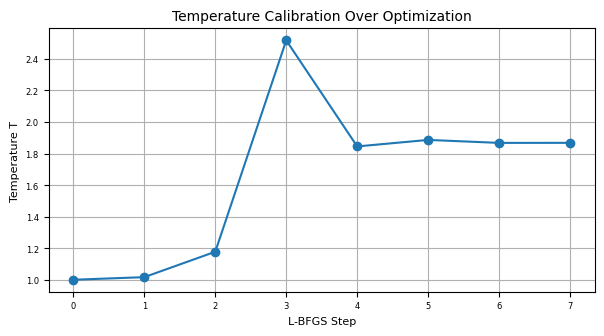

In [12]:
plt.plot(history, marker='o')
plt.xlabel("L-BFGS Step")
plt.ylabel("Temperature T")
plt.title("Temperature Calibration Over Optimization")
plt.grid(True)
plt.show()

In [13]:
print(f"Optimal Temperature T*: {model.temperature:.4f}")

Optimal Temperature T*: 1.8677


## Mean Variance Estimation

In [14]:
# training the model
early_stop_callback = EarlyStopping(monitor="validation_loss", mode="min", patience=14, verbose=True)

warmup_callback = NLLWarmupCallback(warmup_epochs=10)

mve_trainer = pl.Trainer(
    max_epochs=1000,
    accelerator="gpu",
    devices=devices,
    enable_progress_bar=True,
    callbacks=[early_stop_callback, warmup_callback],
    logger=logger,
)
checkpoint_path = get_latest_checkpoint_path(model_path, model_name + "_mve")
mve_model = load_model(
    str(checkpoint_path),
    model_class=SegmentationModel_mve,
    in_channels=2,
    out_channels=2,
    blocks=3,
    hidden_layers_block1=128,
    lr=0.0002,
    lr_scheduler_patience=7,
    regression=False,
)
mve_model.trainer = mve_trainer
if checkpoint_path is None:
    # Train from scratch
    mve_trainer.fit(mve_model, train_loader, val_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Found existing checkpoints: [PosixPath('../../data/cloud/tb_logs/unet_model_mve/version_0/checkpoints/epoch=101-step=4896.ckpt')]. Using the latest one for training.
Loading checkpoint from ../../data/cloud/tb_logs/unet_model_mve/version_0/checkpoints/epoch=101-step=4896.ckpt
Model loaded from ../../data/cloud/tb_logs/unet_model_mve/version_0/checkpoints/epoch=101-step=4896.ckpt


## Evaluate uncertainty Quantification success

### Predict logits and collect target label masks

In [15]:
calibrated_logits = torch.cat(trainer.predict(model, test_loader), dim=0).to(device_name)
labels = torch.cat([l for _, l in test_loader], dim=0).to(device_name)
mve_logits = torch.cat([l for l, _ in mve_trainer.predict(mve_model, test_loader)], dim=0).to(device_name)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: |          | 0/? [00:00<?, ?it/s]

### Compute negative log likelyhood

In [16]:
nll_uncalibrated = compute_nll(uncalibrated_logits, labels)
nll_calibrated = compute_nll(calibrated_logits, labels)
nll_mve = compute_nll(mve_logits, labels)

In [17]:

print(f"\nNegative Log-Likelihood (Uncalibrated): {nll_uncalibrated:.4f}")
print(f"Negative Log-Likelihood (Calibrated):   {nll_calibrated:.4f}")
print(f"Negative Log-Likelihood (MVE):          {nll_mve:.4f}")


Negative Log-Likelihood (Uncalibrated): 0.0186
Negative Log-Likelihood (Calibrated):   0.0117
Negative Log-Likelihood (MVE):          0.0172


### Compute ECE

In [18]:
# Compute ECE on test set
uncalibrated_probs = torch.sigmoid(uncalibrated_logits)
calibrated_probs = torch.sigmoid(calibrated_logits)
with torch.no_grad():
    mve_model.to(device_name)
    mve_probs = torch.cat([mve_model.predict_probabilities((x.to(device_name), y)) for x, y in test_loader], dim=0).to(device_name)
ece_uncalibrated = compute_ece(uncalibrated_probs, labels)
ece_calibrated = compute_ece(calibrated_probs, labels)
ece_mve = compute_ece(mve_probs, labels)

print(f"\nECE (Uncalibrated): {ece_uncalibrated:.6f}")
print(f"ECE (Calibrated):   {ece_calibrated:.6f}")
print(f"ECE (MVE):         {ece_mve:.6f}")


ECE (Uncalibrated): 0.001809
ECE (Calibrated):   0.001348
ECE (MVE):         0.001891


### Plot reliability diagram

<Axes: title={'center': 'reliability diagram'}, xlabel='confidence', ylabel='accuracy'>

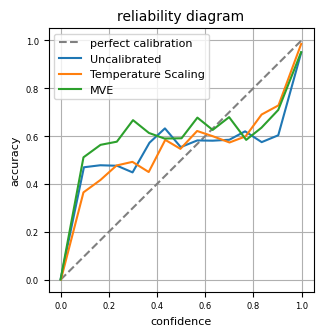

In [19]:
prob_list = [uncalibrated_probs, calibrated_probs, mve_probs]
legend_labels = ["Uncalibrated", "Temperature Scaling", "MVE"]
plot_reliability_diagram(prob_list, labels, legend_labels=legend_labels)

### Plot confidence map

In [20]:
def plot_confidence_map_and_input(
   test_loader, calibrated_probs, index=0, axs=None, fig=None
):
    if axs is None:
        fig, axs = plt.subplots(1, 4, figsize=(textwidth, textwidth/4.1))
    images, labels = test_loader.dataset[index]
    axs[0].imshow(images[1].cpu(), cmap="gray")
    axs[0].set_title("input image")
    axs[0].axis("off")
    labels[labels>0] = 3  # binarize for display
    plot_confidence_map(labels[0], ax=axs[1], fig=fig, color_bar=False)
    axs[1].set_title("target label")

    single_image_set = torch.utils.data.Subset(test_loader.dataset, [index])
    imageloader = torch.utils.data.DataLoader(single_image_set, batch_size=1)

    confidence_map = probs_to_confidence_map(calibrated_probs[index][0])
    plot_confidence_map(confidence_map.cpu(), ax=axs[2], fig=fig, color_bar=False)
    axs[2].set_title("temp. scaling")
    mve_confidence_map = probs_to_confidence_map(mve_probs[index][0])
    plot_confidence_map(mve_confidence_map.cpu(), ax=axs[3], fig=fig)
    axs[3].set_title("MVE")

    fig.tight_layout()

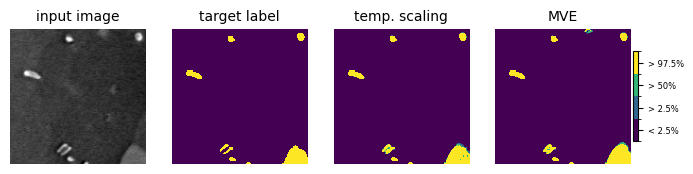

In [21]:
fig, axs = plt.subplots(1, 4, figsize=(textwidth, textwidth / 4.1))
plot_confidence_map_and_input(test_loader, calibrated_probs, index=18, axs=axs, fig=fig)

## Figure for supplementary material

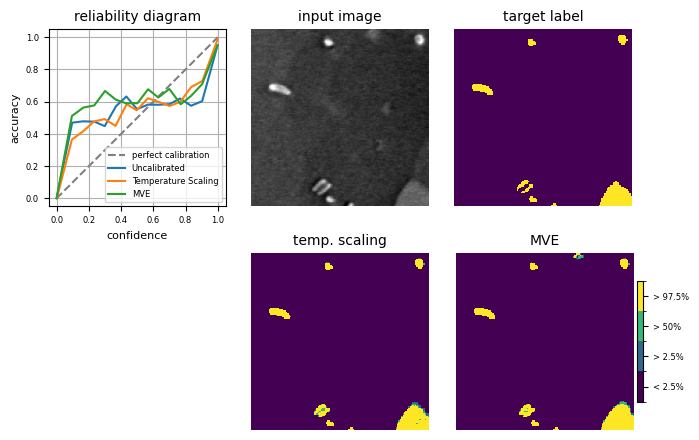

In [22]:
layout = [["rel", "input", "labels"], ["none", "mve", "temp"]]
fig, axs_dic = plt.subplot_mosaic(layout, figsize=(textwidth, textwidth * 0.63))
ax = list(axs_dic.values())
plot_confidence_map_and_input(
   test_loader, calibrated_probs, index=18, axs=[ax[i] for i in (1, 2, 4, 5)], fig=fig
)
plot_reliability_diagram(prob_list, labels=labels, legend_labels=legend_labels, ax=ax[0])
# make axis[2] the same size as axis[0] and axis[1]
ax[0].set_box_aspect(1)  # Set aspect ratio to be 1:1 (square)
# hide ax[3]
ax[3].set_visible(False)
# reduce font size of legend
ax[0].legend(fontsize=6, loc='lower right')
fig.tight_layout()
fig.savefig(figure_path / "reliability_and_confidence_map.svg", bbox_inches='tight', dpi=300)